## DEL-06 Programming Excercise - Optimization
### (created by Prof. Dr.-Ing. Christian Bergler & Prof. Dr. Fabian Brunner)

Documentation: **Python-Bibliothek Pandas** - https://pandas.pydata.org/docs/

Documentation: **Numpy** - https://numpy.org/doc/

Documentation: **Sklearn** - https://scikit-learn.org/stable/index.html

Documentation: **Matplotlib** - Documentation: https://matplotlib.org/stable/index.html

Documentation: **Matplotlib** - Graphics Gallery: https://matplotlib.org/2.0.2/gallery.html

Additional Documentation: **Python Tutorial** - https://docs.python.org/3/tutorial/

Additional Documentation: **Matthes Eric, "Python crash course: A hands-on, project-based introduction to programming"**, ISBN: 978-1-59327-603-4, ©2023 no starch press  

In this exercise, the different variants of the gradient method will be analyzed. For this purpose, the stochastic gradient method is implemented using minibatches (minibatch stochastic gradient descent) for the minimisation of the least squares functional in linear regression. The classical gradient method and the stochastic gradient method are obtained as a special case of this by selecting the minibatch lengths $m$ and $1$ respectively.

### Task DEL-06-1 (Creating Mini-Batches)

Implement a function named ``create_mini_batches``, which generates mini-batches of a given length (``batch-size``), based on a dataset ``X`` target vector ``y`` <br>
<b>Hint</b>: Use the function ``numpy.random.shuffle``.

In [2]:
import numpy as np 

In [3]:
def create_mini_batches(X, y, batch_size):
    """
    Create mini batches of length batch_size from a given dataset X and the corresponding target vector y. 
    The mini batches are drawn randomly from the data set and form a disjoint decomposition of it. If the dataset length is 
    not a multiple of batch_size, the last mini batch may contain less than bach_size records.

    :param X: batch of training data
    :type X: numpy array of shape (n_samples, n_features)
    :param y: target values corresponding to records in X 
    :type y: numpy array of shape (n_samples, )

    :return: list of tuples (X_b, y_b) where X_b and y_b are numpy arrays representing the mini batches.    
    :rtype: list
    """ 
        
    # Ensure the data is shuffled
    permutation = np.random.permutation(X.shape[0])
    X_shuffled = X[permutation]
    y_shuffled = y[permutation]

    mini_batches = []
    
    # Create mini-batches
    for i in range(0, X.shape[0], batch_size):
        X_batch = X_shuffled[i:i + batch_size]
        y_batch = y_shuffled[i:i + batch_size]
        mini_batches.append((X_batch, y_batch))
    
    return mini_batches

### Task DEL-06-2 (Linear Regression with Mini-Batches)

Complete the following class ``MyLinearRegression``, in which a linear model approach of the form 

$$f_{\vec{\theta}}(\vec{x})=\theta_0+\theta_1x_1+\ldots+\theta_px_p$$

is to be fitted. In the ``fit`` method, the gradient method using minibatches is realized to minimize the least squares functional.

$$L(\vec{\theta})=\frac{1}{2m}\sum_{i=1}^m (f_{\vec{\theta}}(\vec{x}^{(i)})-y^{(i)})^2~$$

In [39]:
import numpy as np

class MyLinearRegression:
    def __init__(self, lr, n_epoch):
        self.lr = lr  # learning rate
        self.n_epoch = n_epoch  # number of epochs
        self.theta = None  # parameter vector
    
    def loss(self, X, y):
        """
        Calculate least squares loss for a labeled dataset (X,y) in vectorized form
        
        :param X: batch of data of dimension n_samples x n_features
        :type X: numpy array of shape (n_samples, n_features)
        :param y: target values corresponding to records in X 
        :type y: numpy array of shape (n_samples,)
        
        :return: least squares loss evaluated
        :rtype: float
        """
        m = X.shape[0]
        predictions = X.dot(self.theta)
        loss = (1 / (2 * m)) * np.sum((predictions - y) ** 2)
        return loss
    
    def fit(self, X, y, batch_size=None):
        """
        Model training using minibatch gradient descent optimization algorithm to minimize least squares loss
        
        :param X: batch of training data 
        :type X: numpy array of shape (n_samples,n_features)
        :param y: target values corresponding to records in X 
        :type y: numpy array of shape (n_samples,)
        :param batch_size: minibatch size
        :type batch_size: int
        
        :return: loss history containing the values of the loss function after each parameter update
        :rtype: list of tuples (t_epoch, loss) where t_epoch is the ratio between the total number of samples used for 
        parameter updates so far and the number of samples in X; hence, t_epoch corresponds to the (fractional) number
        of epochs carried out so far)
        """
        m, n = X.shape
        self.theta = np.zeros(n)
        loss_history = []
        theta_history = []

        if batch_size is None:
            batch_size = m

        for epoch in range(self.n_epoch):
            mini_batches = create_mini_batches(X, y, batch_size)
            for X_mini, y_mini in mini_batches:
                m_mini = X_mini.shape[0]
                predictions = X_mini.dot(self.theta)
                gradient = (1 / m_mini) * X_mini.T.dot(predictions - y_mini)
                self.theta -= self.lr * gradient

                # Calculate loss for this mini-batch
                current_loss = self.loss(X, y)
                loss_history.append((epoch + len(loss_history) / len(mini_batches), current_loss))
                theta_history.append(self.theta.copy())

        return theta_history, loss_history

    def predict(self, X):
        """
        Predict values for each sample in a given batch X
        
        :param X: batch of data
        :type X: numpy array
        :return: predicted values for the records in X
        :rtype: numpy array
        """
        return X.dot(self.theta)

    def score(self, X, y):
        """
        Compute the coefficient of determination (R²=1-RSS/TSS) for a given 
        batch X and the corresponding predictions y
        
        R²	= 	coefficient of determination
        RSS	= 	residual sum of squares
        TSS	= 	total sum of squares
        
        :param X: batch of data
        :type X: numpy array
        :param y: true values
        :type y: numpy array
        :return: R² score
        :rtype: float
        """
        y_pred = self.predict(X)
        rss = np.sum((y - y_pred) ** 2)
        tss = np.sum((y - np.mean(y)) ** 2)
        r2 = 1 - (rss / tss)
        return r2

### Task DEL-06-3 (Testing Existing Linear Regression)

In this task, the class ``MyLinearRegression`` is to be tested. First, synthetic training data is generated:

In [25]:
X = np.random.randn(2000).reshape(-1,1)
y = (2*X+1+2*np.random.randn(X.shape[0]).reshape(-1,1)).reshape(-1)

print("Shape of Data X=", X.shape)
print("Shape of Label y=", y.shape)

Shape of Data X= (2000, 1)
Shape of Label y= (2000,)


##### Scatter diagram of the values

Text(0, 0.5, 'y')

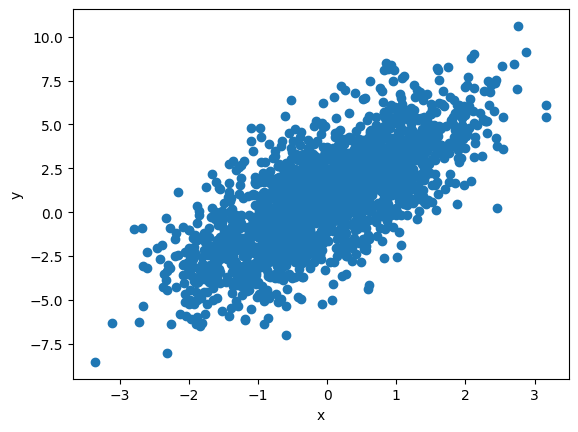

In [6]:
import matplotlib.pyplot as plt
scatter = plt.scatter(X.reshape(-1),y)
plt.xlabel('x')
plt.ylabel('y')

##### Train-Test-Split Partitioning

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Reference Solution Using Existing Scikit-learn Implementation

In [8]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

##### Output $\theta_0$

In [9]:
sklearn_intercept = lr.intercept_
print(sklearn_intercept)

0.9563633630982022


##### Output $\theta_1$

In [10]:
sklearn_slope = lr.coef_
print(sklearn_slope)

[2.0365724]


- Plot the respective `regression line` to the `scatter plot`, using the `slope`, `intersect` and `dataset` values

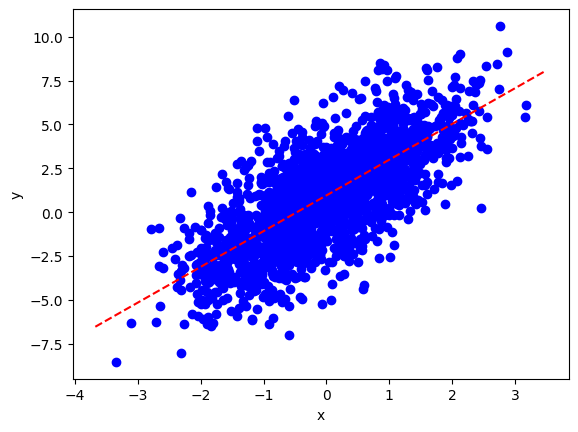

In [16]:
axes = plt.gca()
plt.scatter(X.reshape(-1),y, c='blue')
x_vals = np.array(axes.get_xlim())
y_vals = sklearn_intercept + sklearn_slope * x_vals
plt.plot(x_vals, y_vals, '--', c='red')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
# TODO

##### Model Validation Using the Coefficient of Determination

In [17]:
lr.score(X_train, y_train)

0.5304089491256727

In [18]:
lr.score(X_test, y_test)

0.4522689770610744

### Task DEL-06-4 (Using Own Linear Regression)

Now use the class ``MyLinearRegression`` to fit the model to the training data. Test different values for the size of the mini-batches and visualize the time course of the values of the least squares error function in each case. Use the constant learning rate $\alpha=0.5$ for the tests and carry out the model training over an user-specific number of epochs. Output the final score on the training dataset and on the test dataset. A `batch_size` of `None` should result in `batch gradient descent` while a `batch_size=1` is equal to `stochastic gradient descent`. Any other `batch_size=m` results in `mini-batch gradient descenct`. Also experiment with the `n_epochs`. First create an object of `MyLinearRegression` and call the `fit` method. Afterwards `plot` the `loss history`.

Batch size: None
Final test score (R^2): 0.3880409902508716
---
Batch size: 1
Final test score (R^2): 0.3972144870560357
---
Batch size: 5
Final test score (R^2): 0.36711782577102714
---


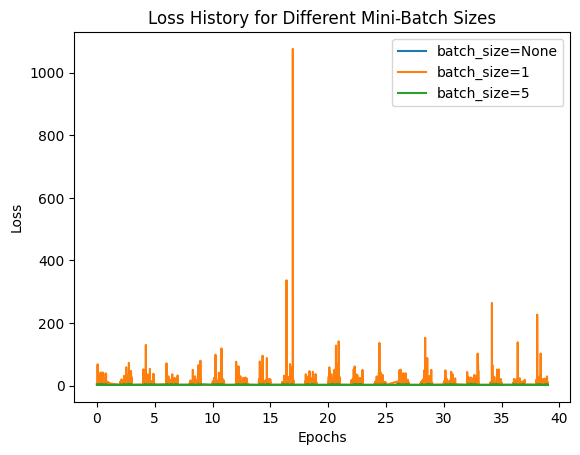

In [60]:
# Parameters
learning_rate = 0.5
n_epochs = 20

# Batch sizes to test
batch_sizes = [None, 1, 5]
theta_histories = {}

# Train and plot loss history for each batch size
for batch_size in batch_sizes:
    model = MyLinearRegression(lr=learning_rate, n_epoch=n_epochs)
    theta_history, loss_history = model.fit(X_train, y_train, batch_size=batch_size)

    theta_histories[batch_size] = theta_history
    # Extract loss values
    epochs, losses = zip(*loss_history)
    
    plt.plot(epochs, losses, label=f'batch_size={batch_size}')
    
    # Output final scores
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    print(f'Batch size: {batch_size}')
    print(f'Final test score (R^2): {test_score}')
    
    print('---')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss History for Different Mini-Batch Sizes')
plt.legend()
plt.show()


- Get your `slope` (`theta[1]`) and `intercept` (`theta[0]`) value by accessing the public attribute `theta`
- Compare the values of `sklearn` with the one of the `MyLinearRegression` class 

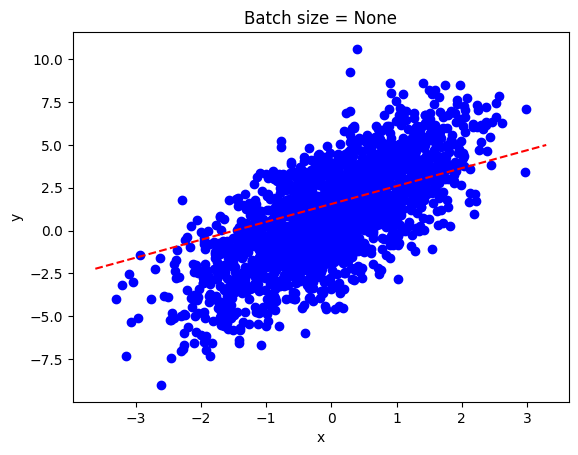

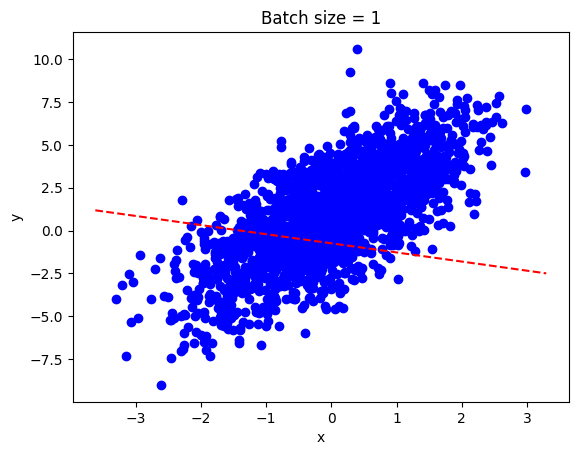

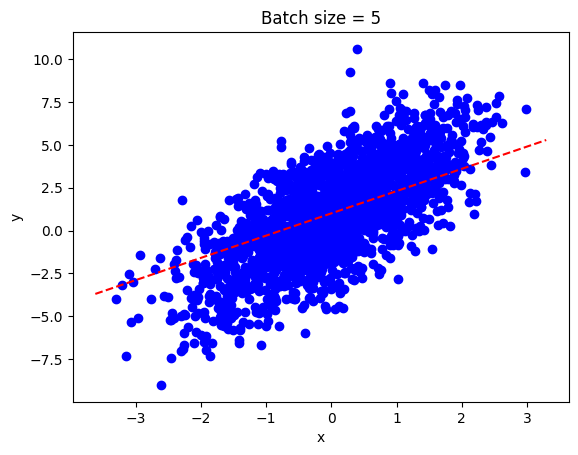

In [59]:
for i in theta_histories.keys():
    axes = plt.gca()
    plt.scatter(X.reshape(-1),y, c='blue')
    x_vals = np.array(axes.get_xlim())
    y_vals = theta_histories[i][1] + theta_histories[i][0] * x_vals
    plt.plot(x_vals, y_vals, '--', c='red')
    plt.title(f"Batch size = {i}")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()


##### Model Validation Using the Coefficient of Determination

In [30]:
# TODO 